In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

DATA_PATH: str = "../data/raw/ABSCHRIFTEN14102023125147047.xlsx"

# Load Data

In [2]:
def read_data(path) -> pd.DataFrame:
    # Read excel file and specify column names
    df = pd.read_excel(path, names=["Kalendertag", "Artikelnummer", "Artikelbeschreibung", "GTIN", "Abschriften Menge"])
    # Convert date column to date type
    df["Kalendertag"] = pd.to_datetime(df["Kalendertag"], dayfirst="True")
    return df

df = read_data(DATA_PATH)
df.head(5)

,Kalendertag,Artikelnummer,Artikelbeschreibung,GTIN,Abschriften Menge
0,2020-03-02,8109277,MBK RUSTIC SERRANO,25007909,-2.0
1,2020-03-02,794366005,BAK MINISCHNECKE 74G,4314131005442,-94.0
2,2020-03-02,829282003,BAK KARTOFFEL NUSS STANGE 450G,4314131001901,-3.0
3,2020-03-02,829382002,BAK HEFE-NUSS-STRIEZEL 500G,4314131007163,-3.0
4,2020-03-02,2231231000,BAK HEFE-ROSINENSCHNECKE,4314131005206,-1.0


# Clean Data

In [3]:
def clean_df(df) -> pd.DataFrame:
    # Convert to positive numbers
    df["Abschriften Menge"] = df["Abschriften Menge"] * (-1)
    # Replace negative Values with 0
    df["Abschriften Menge"] = df["Abschriften Menge"].apply(lambda x : x if x > 0 else 0.0)

    return df

df = clean_df(df)

# EDA

In [4]:
def get_top_k_foodwasters(df: pd.DataFrame, k: int = 20) -> pd.Series:
    return df[["Artikelbeschreibung", "Abschriften Menge"]].groupby("Artikelbeschreibung").sum().sort_values(by="Abschriften Menge", ascending=False)[:k]

### SPECIFY NUMBER OF TOP K FOOD WASTER ###
K: int = 10

# Get top k foodwasters with key (Artikelbeschreibung) and as value the sum of 'Abschriften Menge'
top_k_foodwasters: pd.Series = get_top_k_foodwasters(df, k=K)
# Get list of Artikelbeschreibung of the top k foodwaster
top_k_foodwasters_list = list(top_k_foodwasters.index)
# Get df of the top k foodwasters
top_k_foodwasters_df = df[df["Artikelbeschreibung"].isin(top_k_foodwasters_list)]
# Preview
top_k_foodwasters_df

,Kalendertag,Artikelnummer,Artikelbeschreibung,GTIN,Abschriften Menge
1,2020-03-02,794366005,BAK MINISCHNECKE 74G,4314131005442,94.0
5,2020-03-02,2231234009,BAK PLUNDER-NUSS-HOERNCHEN110G,4314131005244,13.0
34,2020-03-02,3489663003,BAK KUERBISKERNBROET.TGL.1.T.,4314131000546,9.0
36,2020-03-02,3489688002,BAK DINKELBROETCHEN 1. TOUR,4314131000607,10.0
51,2020-03-03,794366005,BAK MINISCHNECKE 74G,4314131005442,61.0
...,...,...,...,...,...
19161,2021-04-15,3451030004,BAK LAUGENBREZEL,4314131001529,0.0
19164,2021-04-15,3489738006,BAK MITTAGSBROETCHEN,4314131001918,0.0
19172,2021-04-15,3931215004,MBK KARTOFFELBROET.DUNKEL 110G,4314131072666,0.0
19211,2021-04-24,2231234009,BAK PLUNDER-NUSS-HOERNCHEN110G,4314131005244,7.0


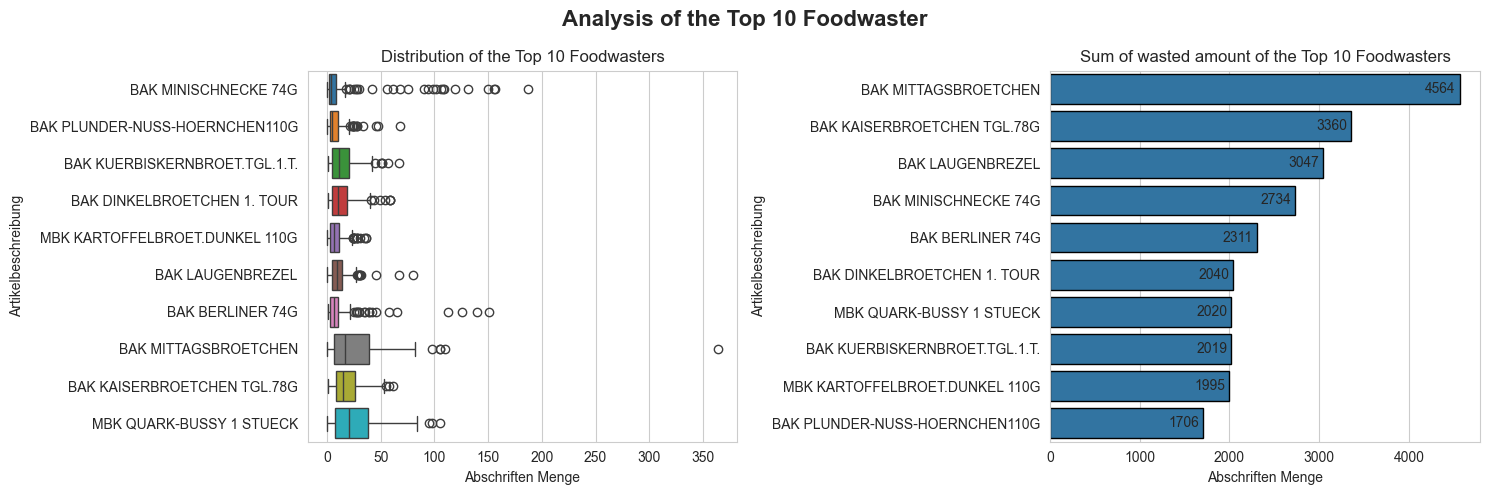

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle(f"Analysis of the Top {K} Foodwaster", fontweight="bold", size=16)
sns.boxplot(data=top_k_foodwasters_df, x="Abschriften Menge", y="Artikelbeschreibung", hue="Artikelbeschreibung", ax=axes[0])
axes[0].set_title("Distribution of the Top 10 Foodwasters")
g = sns.barplot(data=pd.DataFrame(top_k_foodwasters), x="Abschriften Menge", y="Artikelbeschreibung", ax=axes[1], edgecolor="black")
g.bar_label(g.containers[0], padding=-25)
axes[1].set_title("Sum of wasted amount of the Top 10 Foodwasters")
fig.tight_layout()
plt.show()

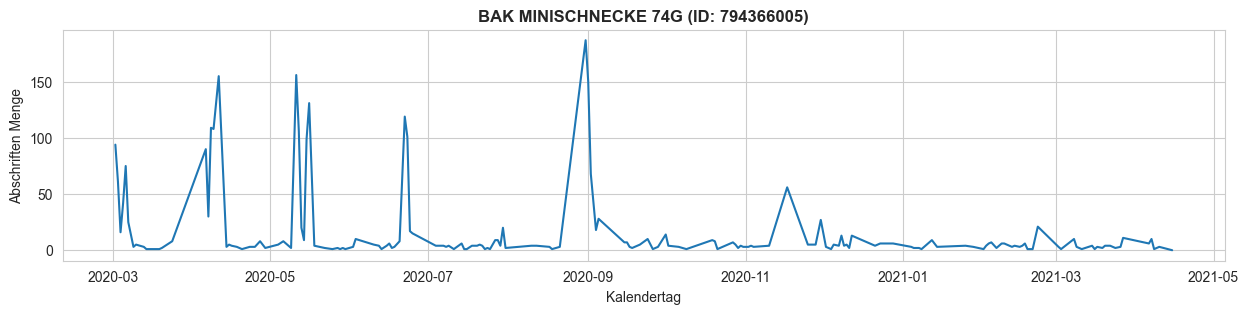

In [6]:
def get_product_df(master_df: pd.DataFrame, id: int) -> pd.DataFrame:
    return master_df[master_df.Artikelnummer == id]

def get_name_of_product_by_id(master_df: pd.DataFrame, id: int) -> str:
    return master_df[master_df["Artikelnummer"] == id]["Artikelbeschreibung"].values[0]

def visualize_product_df(product_df: pd.DataFrame) -> None:
    # Get name of artikel
    name = product_df["Artikelbeschreibung"].values[0]
    id = product_df["Artikelnummer"].values[0]

    plt.figure(figsize=(15, 3))
    plt.title(f"{name} (ID: {id})", fontweight="bold", size=12)
    sns.lineplot(data=product_df, x="Kalendertag", y="Abschriften Menge")
    plt.show()

# Get Artikelnummer(s): list and extra time series from that
product_df = get_product_df(master_df=df, id=794366005)
visualize_product_df(product_df)

# Modelling

In [7]:
def prepare_df(product_df: pd.DataFrame, target: str = "Abschriften Menge") -> pd.DataFrame:
    """ Sets Kalendertag / date as index and drops all other columns except the target / label

    :param product_df: pd.DataFrame -- DataFrame containing only the data for one specific product
    :param target: str -- Name of the target / label
    :return: product_df: pd.DataFrame -- For Training prepared dataframe, contains only label as values and date as keys
    """
    # Set Kalendertag as index
    product_df = product_df.reset_index(drop=True)
    product_df.index = product_df.Kalendertag
    # Keep only target
    product_df = product_df[target]

    return pd.DataFrame(product_df)

In [8]:
def train_test_split(df: pd.DataFrame, last_k_percent: float = 0.1):
    # Get total number of samples
    N = len(df)
    # Get last k percent as absolute value
    k = int(N * last_k_percent)

    # Get first N-k values, e.g. first 250 values
    X_train = df.iloc[:(N-k), :]
    # Get last k values, e.g. last 50 values
    X_test = df.iloc[-k:, :]

    return X_train, X_test


def create_time_features(df):
    """ Create time features from date index

    :param df: pd.DataFrame -- Dataframe that has an date index
    :return: df: pd.DataFrame -- With time features populated df
    """
    df = df.copy()
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    return df


def get_features_and_labels(train_df, test_df, target: str = "Abschriften Menge") -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    X_train = train_df.drop(target, axis =1)
    y_train = pd.DataFrame(train_df[target])

    X_test = test_df.drop(target, axis =1)
    y_test = pd.DataFrame(test_df[target])

    return X_train, y_train, X_test, y_test


def make_prediction(X_test, regressor, target: str = "Abschriften Menge", verbosity: int = 1) -> pd.DataFrame:
    if verbosity > 0:
        print("Making predictions ...")

    # Make prediction
    y_pred = regressor.predict(X_test)
    # Convert to dataframe with index / dates from input features X_test
    y_pred = pd.DataFrame(y_pred, index=X_test.index, columns=[target])
    return y_pred


def concat_data_with_prediction(y_train: pd.DataFrame, y_pred: pd.DataFrame) -> pd.DataFrame:
    """ Adds flaggs to provided y_train and y_pred dataframes and concats them on axis 0, i.e. stacks the vertically.

    :param y_train: pd.DataFrame -- Dataframe containing the y_train
    :param y_pred: pd.DataFrame -- Dataframe containing the y_pred
    :return: df_concat: pd.DataFrame -- Concatenated Dataframe with flag column
    """
    y_train["flag"] = "train"
    y_pred["flag"] = "test"

    df_concat = pd.concat([y_train, y_pred], axis=0)
    return df_concat


def visualize_predictions(df_concat, test_df, product_name, mse, mae, target: str = "Abschriften Menge") -> None:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,3))
    ax.set_title(f"Predicted food waste for Product '{product_name}' (MSE = {mse:.2f}, MAE = {mae:.2f})", fontweight="bold", size=14)
    sns.lineplot(data=df_concat, x="Kalendertag", y=target, hue="flag", ax=ax)
    sns.lineplot(data=test_df, x="Kalendertag", y=target, color="black", ax=ax, label="true", alpha=0.8, linestyle="--")
    plt.show()

Making predictions ...
MSE: 122.41, MAE: 9.23


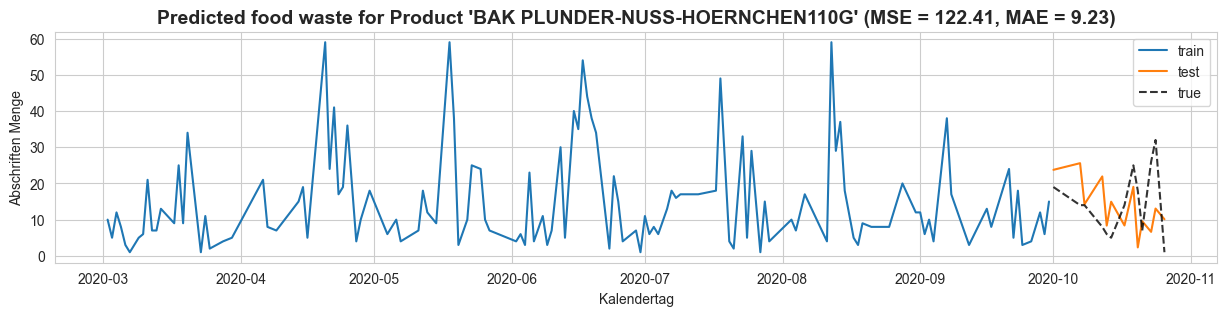

Making predictions ...
MSE: 491.91, MAE: 18.58


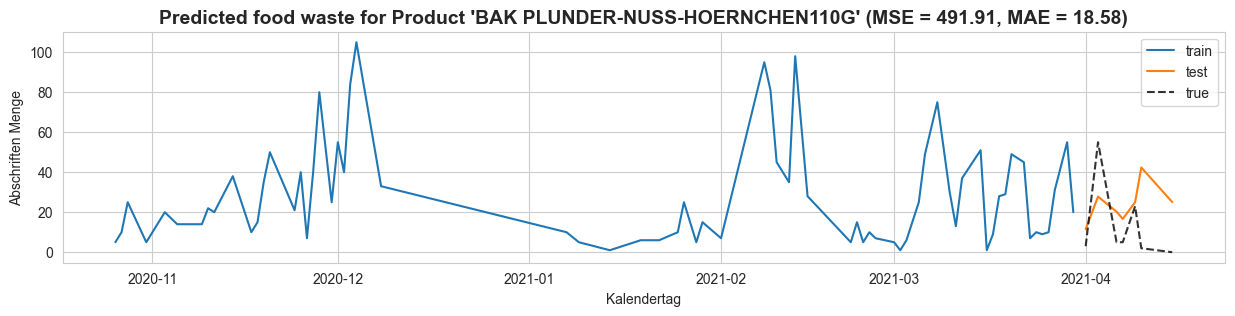

Making predictions ...
MSE: 172.38, MAE: 10.03


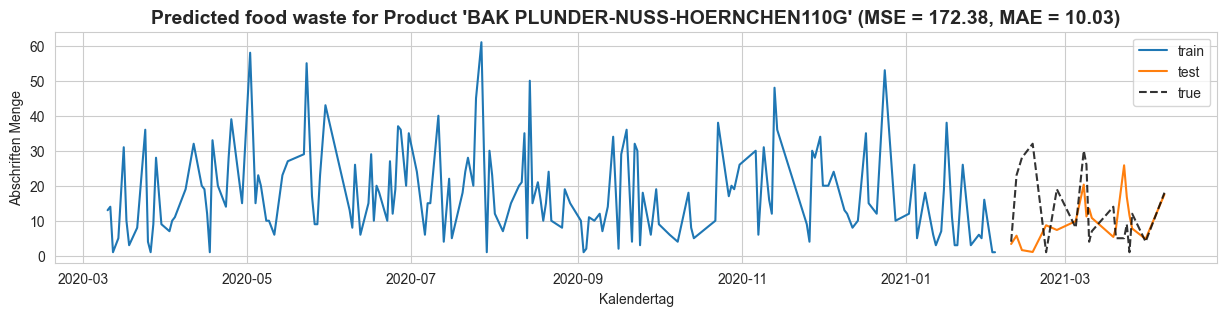

Making predictions ...
MSE: 142.61, MAE: 7.69


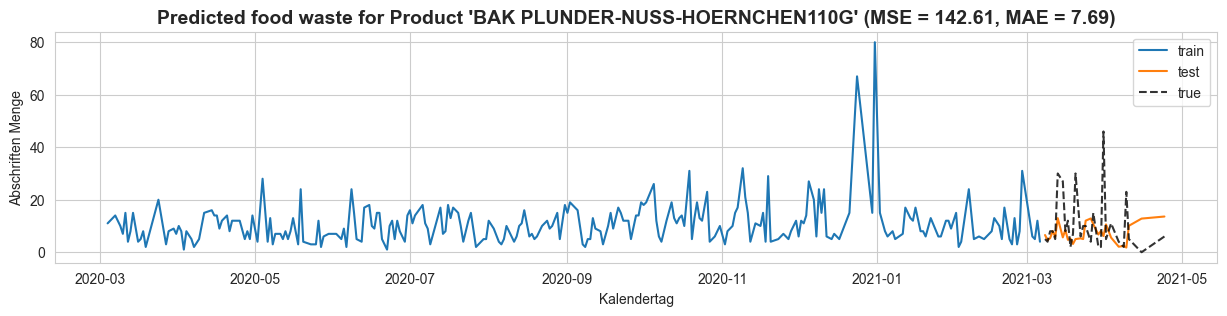

Making predictions ...
MSE: 1168.50, MAE: 22.46


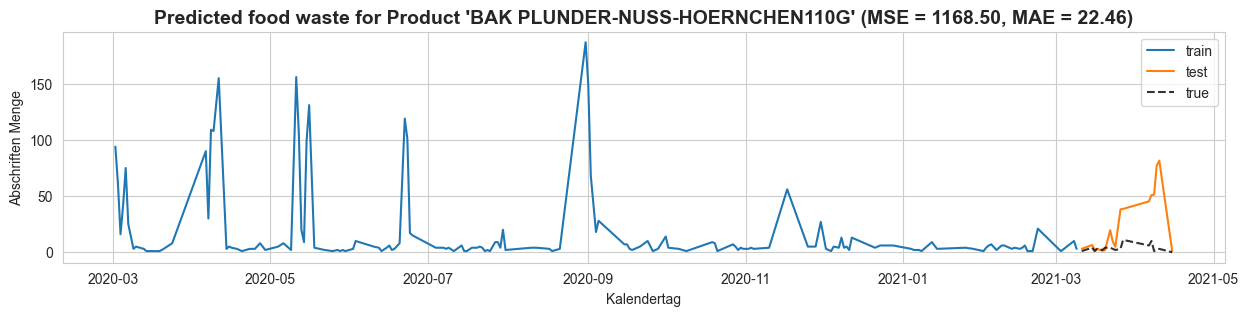

Making predictions ...
MSE: 728.01, MAE: 21.52


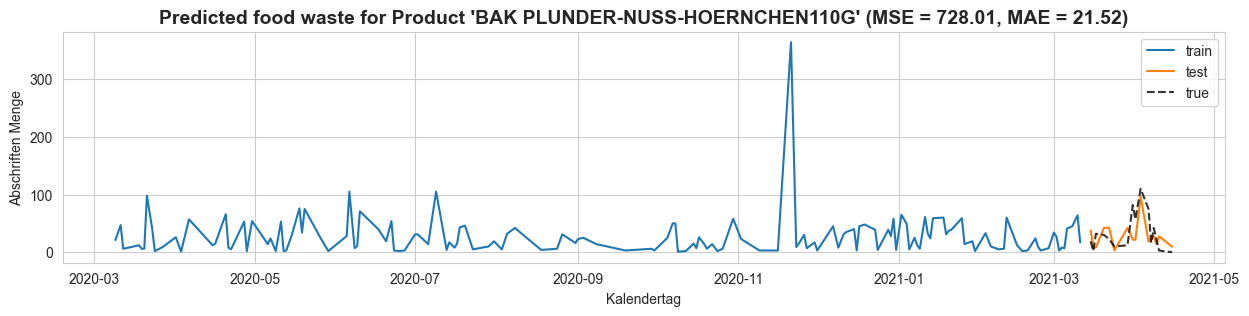

Making predictions ...
MSE: 82.93, MAE: 7.58


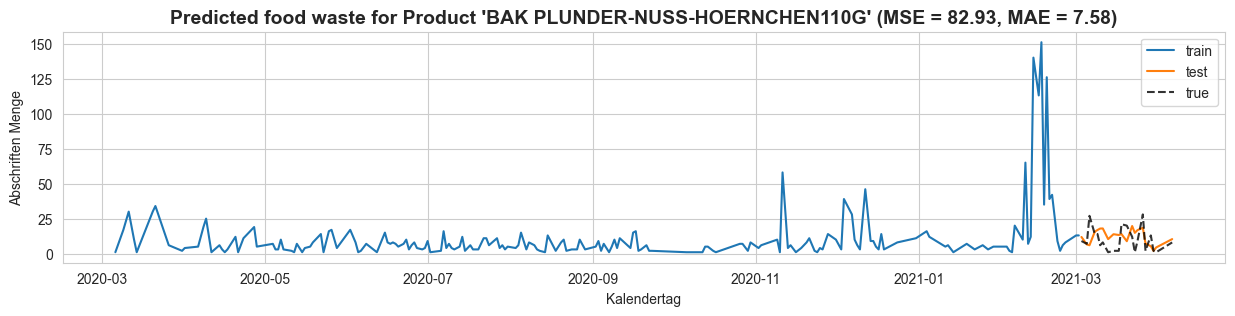

Making predictions ...
MSE: 81.74, MAE: 6.61


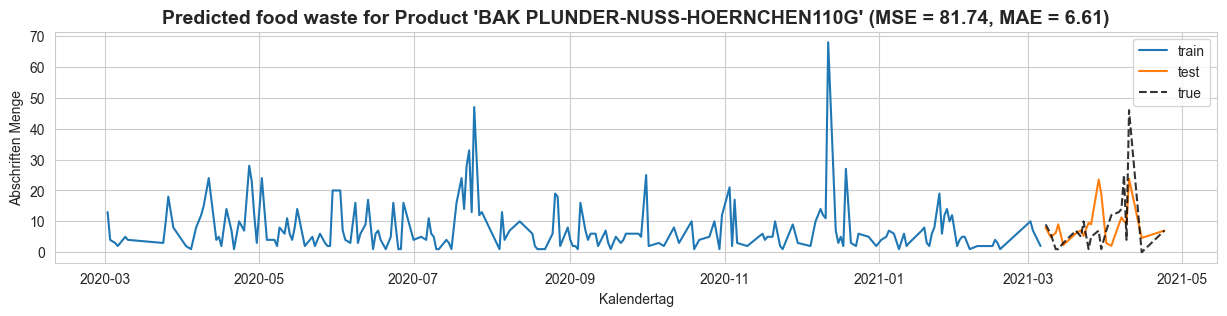

Making predictions ...
MSE: 302.52, MAE: 11.84


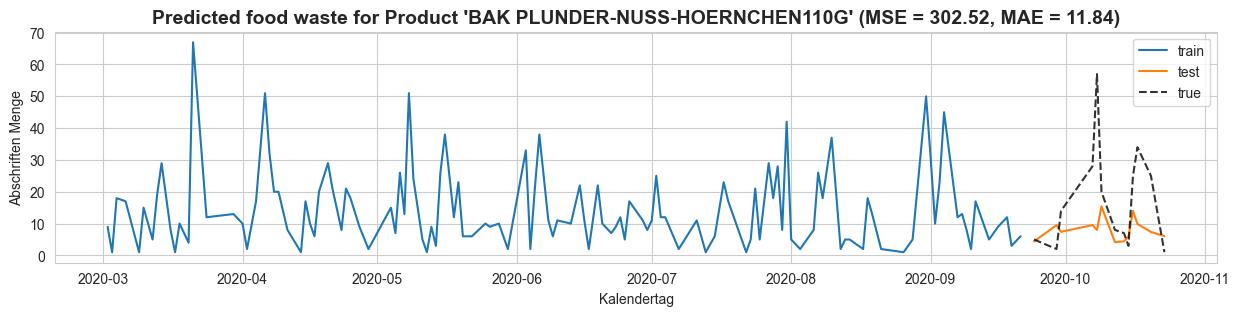

Making predictions ...
MSE: 81.92, MAE: 6.68


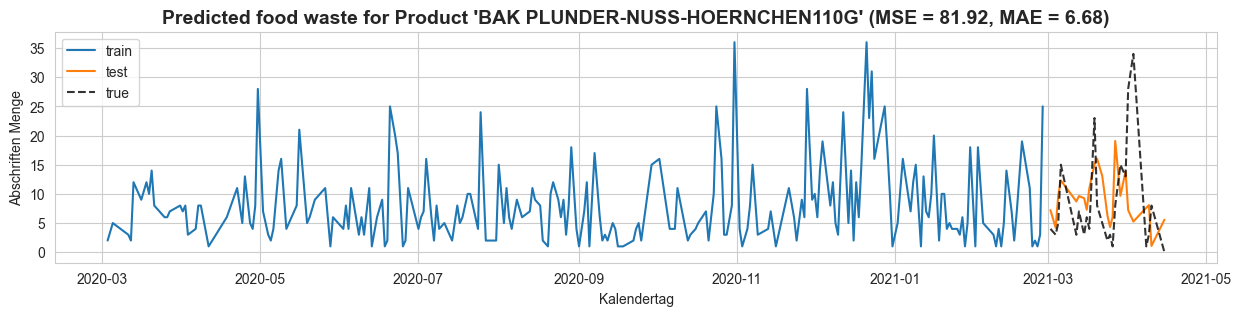

In [9]:
for id in set(top_k_foodwasters_df.Artikelnummer.values):
    product_name = get_name_of_product_by_id(master_df=df, id=2231234009)
    product_df = get_product_df(master_df=df, id=id)
    product_df = prepare_df(product_df)

    # Perform train test split on specified dataframe
    train_df, test_df = train_test_split(product_df, last_k_percent=0.10)
    train_df = create_time_features(train_df)
    test_df = create_time_features(test_df)

    # Get Features and Labels of Train and Test
    X_train, y_train, X_test, y_test = get_features_and_labels(train_df, test_df)

    # Fit Model
    reg = xgb.XGBRegressor(n_estimators=1000)
    reg.fit(X_train, y_train, verbose = False)

    # Get y_pred
    y_pred: pd.DataFrame = make_prediction(X_test, regressor=reg)
    # Evaluate
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    print(f"MSE: {mse:.2f}, MAE: {mae:.2f}")

    # Concat results for plotting
    df_concat = concat_data_with_prediction(y_train=y_train, y_pred=y_pred)
    visualize_predictions(df_concat, test_df, product_name, mse, mae)